In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [100]:
PATH = 'data/New_DB.xlsx'
df = pd.read_excel(PATH)

In [101]:
columns =['slope', 'PP', 'valor_humedad_suelo1']
X = df.loc[:,columns]

In [102]:
df_general = X
n_df_general = X * 0.9
df_general['output'] = 1
n_df_general['output'] = 0

df_output = pd.concat([df_general, n_df_general])

In [103]:
df_output.isnull().sum()

slope                     2
PP                        0
valor_humedad_suelo1    276
output                    0
dtype: int64

In [104]:
X_slope_PP = df_output.drop('valor_humedad_suelo1', axis=1)
X_slope_PP_vhs1 = df_output

In [105]:
X_slope_PP = X_slope_PP.dropna()
X_slope_PP_vhs1 = X_slope_PP_vhs1.dropna()
X_slope_PP = X_slope_PP.reset_index(drop=True)
X_slope_PP_vhs1 = X_slope_PP_vhs1.reset_index(drop=True)

In [106]:
X_slope_PP.shape, X_slope_PP_vhs1.shape

((832, 3), (558, 4))

In [107]:
y_slope_PP = X_slope_PP.output
X_slope_PP = X_slope_PP.drop(labels='output', axis=1)

y_slope_PP_vhs1 = X_slope_PP_vhs1.output
X_slope_PP_vhs1 = X_slope_PP_vhs1.drop(labels='output', axis=1)

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pytensor
import pytensor.tensor as pt
# TODO:
#   Separar el train con y sin vhs y definir correctamente nombre de variables
#   Intentar formato floatX de la forma:
#                                       floatX = pytensor.config.floatX
#                                       "X.astype(floatX)"
sc = StandardScaler()
floatX = pytensor.config.floatX
X_slope_PP_vhs1 = X_slope_PP_vhs1.astype(floatX)
y_slope_PP_vhs1 = y_slope_PP_vhs1.astype(floatX)
X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=0.7, stratify=y_slope_PP_vhs1, random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [109]:
random_seed = 12
rng = np.random.default_rng(random_seed)

In [110]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train, mutable=True, dims=("obs_id", "train_cols"))
        ann_output = pm.Data("ann_output", y_train, mutable=True, dims="obs_id")

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=y_train.shape[0],  # IMPORTANT for minibatches
            dims="obs_id",
        )
    return neural_network


neural_network = construct_nn(X_train, y_train)

In [111]:
%%time
with neural_network:
    approx = pm.fit(n=30_000)

Finished [100%]: Average Loss = 230.18


CPU times: total: 2min 38s
Wall time: 30.6 s


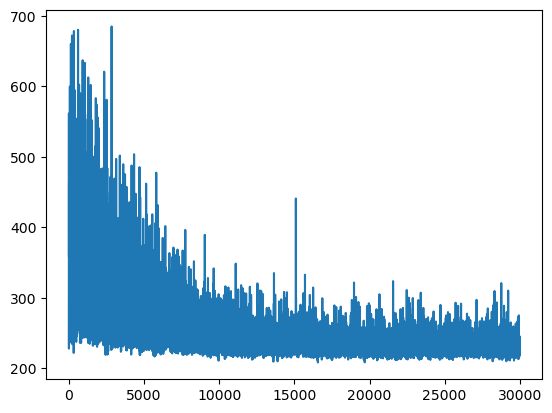

In [112]:
plt.plot(approx.hist)

In [113]:
trace = approx.sample(draws=5000)

In [114]:
with neural_network:
    pm.set_data(new_data={"ann_input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


In [116]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Accuracy = 85.71428571428571%


In [126]:
import bambi as bmb
X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=0.7, stratify=y_slope_PP_vhs1, random_state=42)
X_train = pd.concat([X_train, y_train], axis=1)

In [127]:
X_train

,slope,PP,valor_humedad_suelo1,output
208,62.317567,4.714855,0.380722,1.0
81,42.539396,18.063203,0.506699,1.0
149,41.306525,229.456488,0.438354,1.0
441,32.016397,171.083326,0.394766,0.0
178,36.069685,101.694187,0.438995,1.0
...,...,...,...,...
254,51.436935,78.010678,0.437790,1.0
489,48.434208,11.634952,0.340768,0.0
500,53.163478,1.657459,0.341785,0.0
64,37.616885,282.989359,0.467758,1.0


In [128]:
model1 = bmb.Model("output ~ slope + PP + valor_humedad_suelo1", X_train, family="bernoulli")
fitted1 = model1.fit(draws=1000, idata_kwargs={"log_likelihood": True})

Modeling the probability that output==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, slope, PP, valor_humedad_suelo1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 182 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-10.760,1.352,-13.214,-8.154,0.022,0.016,3835.0,3109.0,1.0
slope,0.030,0.009,0.012,0.046,0.000,0.000,5367.0,3063.0,1.0
PP,-0.002,0.002,-0.005,0.000,0.000,0.000,3889.0,3213.0,1.0
valor_humedad_suelo1,23.663,3.214,17.297,29.352,0.053,0.038,3652.0,3059.0,1.0


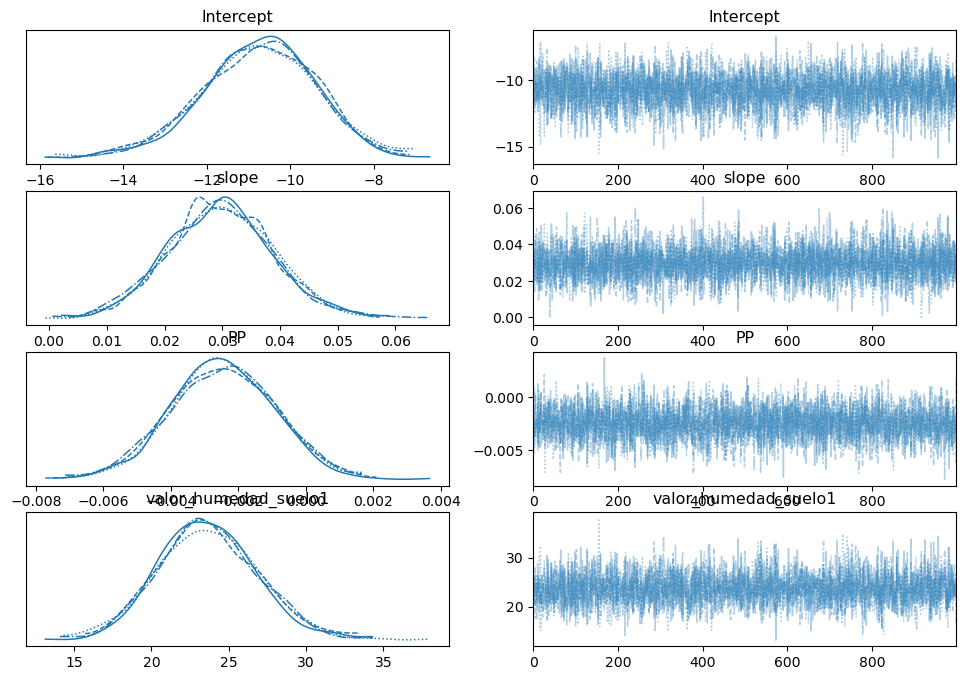

In [129]:
az.plot_trace(fitted1);
az.summary(fitted1)

In [137]:
fitted1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [174]:
pred = model1.predict(fitted1, data=X_test)
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

In [181]:
fitted1.posterior.values.mean()

AttributeError: 'function' object has no attribute 'mean'